In [15]:
# noscript
!jupyter nbconvert --RegexRemovePreprocessor.patterns="['# ?noscript']" --TemplateExporter.exclude_markdown=True --to python compare_metrics_over_datasets.ipynb --output raw_output_small_xgb.py

[NbConvertApp] Converting notebook compare_metrics_over_datasets.ipynb to python
[NbConvertApp] Writing 22766 bytes to raw_output_small_xgb.py


In [1]:
import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt
import tabulate
from tqdm.notebook import tqdm

import openml

import sklearn.metrics
import sklearn.ensemble
import sklearn.svm
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.base
import sklearn.utils
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.neural_network
import sklearn.tree
import xgboost

from ridgereliability import plots, metrics

import os
import multiprocessing
import logging
import time
from joblib import load, dump
from functools import partial

In [2]:
def is_notebook():
    try:
        from IPython import get_ipython
        return get_ipython().__class__.__name__ == 'ZMQInteractiveShell'
    except ModuleNotFoundError:
        return False

In [3]:
if is_notebook():
    n_procs = multiprocessing.cpu_count()//2
    random_tasks = 0
else:
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument("--n-processes", type=int, required=True)
    parser.add_argument("--random-tasks", type=int, default=0)
    args = parser.parse_args()
    n_procs = args.n_processes
    random_tasks = args.random_tasks

In [4]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(name)s %(asctime)s - %(message)s')
logging.captureWarnings(True)
logging.getLogger("openml").setLevel(logging.ERROR)

class NoRequestFilter(logging.Filter):
    def filter(self, record):
        return not "request for the URL" in record.getMessage()

logging.getLogger("root").addFilter(NoRequestFilter())
logging.getLogger().addFilter(NoRequestFilter())

In [5]:
numpy.random.seed(42)

# Compare metrics over datasets

In this notebook we collect calibration estimates for several models and datasets. The estimates are computed with the Expected Calibration Error (ECE), Balanced-ECE, and Posterior Expected Accuracy-based Calibration Error (PEACE). A list of manually selected datasets is available, but in final experiments we used randomly selected datasets from the OpenML repository.

Tested models:
- Random Forest
- SVM
- Logistic Regression
- Gaussian Naive Bayes
- MLP
- AdaBoost
- Decision Tree

Selected datasets (from Open ML):
- [eeg-eye-state](https://www.openml.org/d/1471), task [9983](https://www.openml.org/t/9983)
- [Phoneme](https://www.openml.org/d/1489), task [9952](https://www.openml.org/t/9952)
- [mozilla4](https://www.openml.org/d/1046), task [3899](https://www.openml.org/t/3899)
- [electricity](https://www.openml.org/d/151), task [219](https://www.openml.org/t/219)
- [Magic Telescope](https://www.openml.org/d/1120), task [3954](https://www.openml.org/t/3954)
- [artificial characters](https://www.openml.org/d/1459), task [14964](https://www.openml.org/t/14964)
- [pendigits](https://www.openml.org/d/32), task [32](https://www.openml.org/t/32)
- [letter](https://www.openml.org/d/6), task [6](https://www.openml.org/t/6)
- [JapaneseVowels](https://www.openml.org/d/375), task [3510](https://www.openml.org/t/3510)
- [glass](https://www.openml.org/d/41), task [40](https://www.openml.org/t/40)
- [micro-mass](https://www.openml.org/d/1515), task [9950](https://www.openml.org/t/9950)
- [vehicle](https://www.openml.org/d/54), task [53](https://www.openml.org/t/53)
- [synthetic-control](https://www.openml.org/d/377), task [3512](https://www.openml.org/t/3512)
- [mfeat-factors](https://www.openml.org/d/12), task [12](https://www.openml.org/t/12)
- [OVA_breast](https://www.openml.org/d/1128), task [3962](https://www.openml.org/d/1128)
- [sonar](https://www.openml.org/d/40), task [39](https://www.openml.org/t/39)
- [visualizing_livestock](https://www.openml.org/d/685), task [3577](https://www.openml.org/t/3577)
- [spectrometer](https://www.openml.org/d/313), task [145682](https://www.openml.org/t/145682)
- [disclosure_z](https://www.openml.org/d/931), task [3794](https://www.openml.org/t/3794)
- [mfeat-pixel](https://www.openml.org/d/40979), task [146824](https://www.openml.org/t/146824)

## Datasets

First of all, we need to be able to load and preprocess multiple datasets appropriately to prepare it for classification. 
To this end we implement a function that will load a dataset and classification task from OpenML.

In [124]:
def find_random_task(selected_tasks):
    tries = 0
    while True:
        df = openml.tasks.list_tasks(task_type_id=1, offset=tries*1000, output_format="dataframe", size=1000, status="active", number_missing_values=0)
        tries += 1
        if "NumberOfInstances" in df:
            df = df[(df["NumberOfInstances"] > 2000) & (df["NumberOfInstances"] < 10000)]
            df = df[~df["tid"].isin(list(selected_tasks))]
            if len(df) > 0:
                task = df.sample(n=1).iloc[0]["tid"]
                selected_tasks.append(task)
                return task

In [125]:
LARGE_TASKS = [  3919,   4230,   3601,     30,   3891,   4190,   1792,     43,
         1908,   3786,   2939,   3488,   3843,   3603,    266,   4193,
         3528,   3842,   3525,   3777,   1923,   1809,    275,   3638,
         3684,   1800,   1916,   1794,   2074,     36,   3672,   2120,
          288,   3594,   3712,   3618,   3586,   4229,   3917,   1925,
         3816,   1767,   3668,   1883,   3698,   3907,   4233,   3485,
         3531,   3627,   1822,   3524,   3821,   3681,   3892,   3950,
          233,    260,   3894,   4236,   3884,   3735,   4215,   2121,
          258,   3481,   3839,   3510,     58,   1910,   3591,     28,
          273,     45,      3,   1938,   1807,   4186, 126022,  14969,
       145945,  75100,   4308, 145855,   9898,   4612,  75203,  75216,
       145891, 145985,   9952,   9921,  75169, 145903,  75242,  75124,
        75138,  10091]

In [126]:
SMALL_TASKS = [4240, 4245, 1780,  248, 1896, 3891, 3934, 3611, 3837, 3763, 1784,
       2938,   12,  242, 3918, 3497, 3524, 3614, 3523,  246, 1923, 3925,
        277,   31, 3603, 3653, 3894,   52, 3058,  250, 4196, 3994,    3,
       3584,  252, 4200, 3527, 1787, 3778, 3993, 3841, 3959, 3996, 3846,
       4190, 3933,  275, 1927, 4234, 4238, 3997, 3520, 1892, 4241, 1811,
        266, 3521, 1806, 3635, 1916, 3730, 3806, 3710, 3892, 3657, 3775,
        270, 3491, 3716, 3753, 3676, 3788, 3538, 4235, 3585, 3731, 3702,
       3917, 3821,   45, 3689, 3598,  233, 3995, 2104, 3519, 3735, 1903,
       3777, 4243, 3828, 3733, 3056, 3583, 4225, 3695, 4198, 3617,  261]

In [149]:
DEBUG_TASKS = [4240, 4245, 1780]

In [165]:
if random_tasks > 0:
    TASKS = random_tasks
else:
    TASKS = SMALL_TASKS

In [151]:
# noscript
TASKS = DEBUG_TASKS

In [166]:
def load_openml_task(task_id=None, selected_tasks=[]):
    
    while True:
        if task_id is None:
            curr_id = find_random_task(selected_tasks)
        else:
            curr_id = task_id

        try: 
            task = openml.tasks.get_task(curr_id)
            X, y = task.get_X_and_y("array")
            X, y = sklearn.utils.indexable(X, y)
            
            target_type = sklearn.utils.multiclass.type_of_target(y)
            if target_type not in ["binary", "multiclass"]:
                continue

            if hasattr(X, "toarray"):
                X = X.toarray()
            if hasattr(y, "toarray"):
                y = y.toarray()

            X = sklearn.preprocessing.OrdinalEncoder().fit_transform(X)

            n_repeats, n_folds, n_samples = task.get_split_dimensions()
            
            if n_folds > 10:
                continue

            folds = numpy.full((len(X)), dtype=int, fill_value=-1)
            for fold_idx in range(n_folds):
                _, test_indices = task.get_train_test_split_indices(
                    repeat=0,
                    fold=fold_idx,
                    sample=0,
                )

                folds[test_indices] = fold_idx

            splitter = sklearn.model_selection.PredefinedSplit(folds)

            return X, y, splitter, curr_id
        except Exception as e:
            if task_id is not None:
                raise e

In [ ]:
# noscript
from tqdm.notebook import trange
iter_tasks = []
tmp_tasks = []
for i in trange(100):
    _, _, _, task = load_openml_task(selected_tasks=tmp_tasks)
    iter_tasks.append(task)

In [20]:
# noscript
X, y, splitter, task_id = load_openml_task(DEBUG_TASKS[1])

In [ ]:
# noscript
X, y, splitter, task_id = load_openml_task()

## Getting calibration metrics

For each dataset we fit and evaluate multiple models. We record calibration metrics (ECE, ECE-balanced, PEACE), and some performance metrics (balanced accuracy, F1-score, accuracy). To this end we implement a function that runs this procedure for one model on one OpenML task.

In [13]:
# noscript
MODELS = {
    "rf": sklearn.ensemble.RandomForestClassifier(),
    "logreg": sklearn.linear_model.LogisticRegression(max_iter=1000),
    "nb": sklearn.naive_bayes.GaussianNB(),
    "mlp": sklearn.neural_network.MLPClassifier(max_iter=1000),
    "adaboost": sklearn.ensemble.AdaBoostClassifier(n_estimators=500),
    "dectree": sklearn.tree.DecisionTreeClassifier(),
    "svm": sklearn.linear_model.SGDClassifier(loss="modified_huber", max_iter=1000)
#     "xgb": xgboost.XGBClassifier(tree_method="gpu_hist")
}

In [162]:
# noscript
MODELS = {
    "adaboost_perceptron": sklearn.ensemble.AdaBoostClassifier(base_estimator=sklearn.linear_model.Perceptron(), n_estimators=500)
}

In [14]:
MODELS = {
    "xgb": xgboost.XGBClassifier(tree_method="gpu_hist")
}

In [ ]:
# noscript
MODELS = {
    "svm": sklearn.ensemble.BaggingClassifier(sklearn.svm.SVC(probability=True)),
    "logreg": sklearn.ensemble.BaggingClassifier(sklearn.linear_model.LogisticRegression(max_iter=1000)),
    "nb": sklearn.ensemble.BaggingClassifier(sklearn.naive_bayes.GaussianNB()),
    "mlp": sklearn.ensemble.BaggingClassifier(sklearn.neural_network.MLPClassifier(max_iter=1000)),
    "dectree": sklearn.ensemble.BaggingClassifier(sklearn.tree.DecisionTreeClassifier())
}

In [154]:
# noscript
MODELS = {
    "dummy": sklearn.dummy.DummyClassifier(strategy="prior")
}

In [155]:
def fit_and_predict(model_id, Xt, yt, Xv, yv):
    # get and fit fresh model
    model = sklearn.base.clone(MODELS[model_id])
    model.fit(Xt, yt)

    # predict on test
    y_probs = model.predict_proba(Xv)
    y_preds = model.predict(Xv)
    
    return y_probs, y_preds, yv

In [156]:
def get_cv_metrics_for_model_and_task(model_id, task_id, pool, selected_tasks):
    X, y, splitter, task_id = load_openml_task(task_id, selected_tasks=selected_tasks) # repeated runs will use cached data
    
    row = {
        "model_id": model_id,
        "task_id": task_id,
    }

    promises = []
    for i, (train_idx, test_idx) in enumerate(splitter.split()):

        # split data
        Xt, yt = X[train_idx], y[train_idx]
        Xv, yv = X[test_idx], y[test_idx]

        promise = pool.apply_async(
            fit_and_predict,
            (model_id, Xt, yt, Xv, yv)
        )
        promises.append(promise)

    logging.info(f"Promises for single cv: {len(promises)}")
    return row, promises

## Data collection over all datasets and models

In [157]:
with multiprocessing.Pool(processes=n_procs) as pool:

    start_at = 0

    output_file = f"metrics_{int(time.time())}.dat"
    logging.info(f"Output to {output_file}")
    
    if type(TASKS) is int:
        iter_tasks = []
        tmp_tasks = []
        for i in range(TASKS):
            _, _, _, task = load_openml_task(selected_tasks=tmp_tasks)
            iter_tasks.append(task)
    else:
        iter_tasks = TASKS[start_at:]
        
    logging.info(f"Tasks: {iter_tasks}")
    
    data = []
    for model_id in MODELS.keys():
        
        logging.info(f"Start submitting promises for {model_id}")
        
        promises = []
        for task_id in iter_tasks:
            row, tmp = get_cv_metrics_for_model_and_task(model_id, task_id, pool, [])
            promises.append((row, tmp))
            logging.info(f"{len(promises)} tasks submitted to pool ({model_id})")
        logging.info(f"All {len(promises)} tasks submitted to pool ({model_id})")

        for i, (row, promise) in enumerate(promises):
            try:
                y_probs, y_preds, y_test = [], [], []
                for x in promise:
                    x = x.get()
                    y_probs.extend(x[0])
#                     y_preds.extend(x[1])
                    y_test.extend(x[2])

                # stack fold results and compute metrics
                y_probs = numpy.array(y_probs)
#                 logging.debug(y_probs.shape)
#                 y_probs_max = y_probs.max(axis=1)
#                 y_preds = numpy.array(y_preds)
                y_test = numpy.array(y_test)

                row.update({
                    "y_probs": y_probs,
                    "y_test": y_test
                })
    
#                 bins = "count"
#                 row.update({
#                     "accuracy": sklearn.metrics.accuracy_score(y_test, y_preds),
#                     "balanced_accuracy": sklearn.metrics.balanced_accuracy_score(y_test, y_preds),
#                     "f1": sklearn.metrics.f1_score(y_test, y_preds, average="weighted"),
#                     'ece_count': metrics.ece(y_probs_max, y_preds, y_test, bins=bins),
#                     'ece_balanced_count': metrics.ece(y_probs_max, y_preds, y_test, balanced=True, bins=bins),
#                     'peace_count': metrics.peace(y_probs_max, y_preds, y_test, bins=bins),
#                     'class_wise_ece': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.ece, bins=bins),
#                     'class_wise_peace': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.peace, bins=bins)
#                 })

                # update data and dump intermediate dataframe
                data.append(row)
#                 df = pandas.DataFrame(data)
                dump(data, output_file)

                logging.info(f"Finished tasks: {i+1}/{len(promises)} ({(i+1)/len(promises)*100:.2f}%)")
            except Exception:
                logging.exception("Exception when collecting results")

INFO: root 2020-10-12 13:21:36,827 - Output to metrics_1602501696.dat
INFO: root 2020-10-12 13:21:36,828 - Tasks: [4240, 4245, 1780]
INFO: root 2020-10-12 13:21:36,829 - Start submitting promises for dummy
INFO: root 2020-10-12 13:21:38,818 - Promises for single cv: 10
INFO: root 2020-10-12 13:21:38,820 - 1 tasks submitted to pool (dummy)
INFO: root 2020-10-12 13:21:38,838 - Promises for single cv: 10
INFO: root 2020-10-12 13:21:38,839 - 2 tasks submitted to pool (dummy)
INFO: root 2020-10-12 13:21:40,529 - Promises for single cv: 2
INFO: root 2020-10-12 13:21:40,530 - 3 tasks submitted to pool (dummy)
INFO: root 2020-10-12 13:21:40,531 - All 3 tasks submitted to pool (dummy)
INFO: root 2020-10-12 13:21:40,535 - Finished tasks: 1/3 (33.33%)
INFO: root 2020-10-12 13:21:40,537 - Finished tasks: 2/3 (66.67%)
INFO: root 2020-10-12 13:21:40,540 - Finished tasks: 3/3 (100.00%)


In [ ]:
if not is_notebook():
    exit()

# Metric analysis

## Load data

In [6]:
def get_longform(df, subject_cols=[]):
        
    df = pandas.melt(df, id_vars=subject_cols)
            
    if len(subject_cols) > 0:
        df["subject"] = df[subject_cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
        
    return df

In [7]:
cols = ["ECE", "Balanced ECE", "PEACE"]

### Raw prob values

In [8]:
data = load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/raw/metrics_1602504941.dat")

def row_func(row, n_bins, eq_count=False):
    
    y_probs = row["y_probs"]
    y_probs_max = y_probs.max(axis=1)
    y_preds = y_probs.argmax(axis=1)
    y_test = row["y_test"]
    
    row.update({
        "n_bins": n_bins,
        "binning": "equal-count" if eq_count else "equal-width",
        "accuracy": sklearn.metrics.accuracy_score(y_test, y_preds),
        "balanced_accuracy": sklearn.metrics.balanced_accuracy_score(y_test, y_preds),
        "f1": sklearn.metrics.f1_score(y_test, y_preds, average="weighted"),
    })
    
    if eq_count:
        try:
            row.update({
                'ece': metrics.ece(y_probs_max, y_preds, y_test, bins="count", n_bins=n_bins),
                'ece_balanced': metrics.ece(y_probs_max, y_preds, y_test, balanced=True, bins="count", n_bins=n_bins),
                'peace': metrics.peace(y_probs_max, y_preds, y_test, bins="count", n_bins=n_bins)
            })
        except AssertionError:
            row.update({
                'ece': np.nan,
                'ece_balanced': np.nan,
                'peace': np.nan
            })
    else:
        row.update({
            'ece': metrics.ece(y_probs_max, y_preds, y_test, bins=n_bins),
            'ece_balanced': metrics.ece(y_probs_max, y_preds, y_test, balanced=True, bins=n_bins),
            'peace': metrics.peace(y_probs_max, y_preds, y_test, bins=n_bins)
        })
    
    del row["y_probs"]
    del row["y_test"]
    
    return row

### Precomputed metrics

In [157]:
tmp_df = load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1601995877.dat") # bagged classifiers
tmp_df["model_id"] = "bagged_" + tmp_df["model_id"]

In [168]:
df = pandas.concat([
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1601494658.dat"), # base results
#     load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602009416.dat"), # large datasets logreg nb mlp rf
#     load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602065288.dat"), # large data adaboost dec
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602080372.dat"), # partial large + small xgb
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602142050.dat"), # remaining xgb
#     load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602148932.dat"), # large + small ada+nb
#     load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602158698.dat"), # large + small ada+perc
])

In [ ]:
df.columns = ["model_id", "task_id", "Accuracy", "Balanced Accuracy", "F1", "ECE", "Balanced ECE", "PEACE", "cw-ECE", "cw-PEACE"]
cols = ["ECE", "Balanced ECE", "PEACE"]

In [108]:
df = pandas.concat([
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1601494658.dat"),
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602238194.dat")[["ece_count", "ece_balanced_count", "peace_count"]] # equal-count binning
], axis=1)
df.columns = ["model_id", "task_id", "Accuracy", "Balanced Accuracy", "F1", "ECE", "Balanced ECE", "PEACE", "cw-ECE", "cw-PEACE", "ECE (c)", "Balanced ECE (c)", "PEACE (c)"]
cols = ["ECE", "Balanced ECE", "PEACE", "ECE (c)", "Balanced ECE (c)", "PEACE (c)"]

In [64]:
df = df[~df.duplicated(["model_id", "task_id"])]

In [65]:
for idx, group_df in df.groupby("model_id"):
    a = sum([(t == group_df["task_id"]).any() for t in LARGE_TASKS])
    b = sum([(t == group_df["task_id"]).any() for t in SMALL_TASKS])
    print(idx, a, b)

adaboost 17 99
dectree 17 99
logreg 17 99
mlp 17 99
nb 17 99
rf 17 99
svm 17 99
xgb 97 99


In [66]:
all_tasks = set(SMALL_TASKS + LARGE_TASKS)
for idx, group_df in df.groupby("model_id"):
    all_tasks = all_tasks.intersection(group_df["task_id"])

In [67]:
df = df[df["task_id"].isin(all_tasks)]

In [173]:
long_df = get_longform(df, ["model_id", "task_id"])

## Compare binning

In this notebook we will compare the impact of binning on the calibration error metrics.

Questions:
- What is the impact of number of bins?
- What is the impact of equal-width versus equal-count binning?
- Is the impact different for different classifiers/metrics?
- Is PEACE somewhat robust against number of bins?

End product: DataFrame with the following row fields
- metrics: ECE, PEACE, Bal-ECE
- classifier
- task id
- number of bins
- equal width or equal count

In [9]:
dfs = []
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    for bins in tqdm(numpy.arange(5, 100, 5)):
        dfs.append(pandas.DataFrame(pool.map(partial(row_func, n_bins=bins), data)))
        dfs.append(pandas.DataFrame(pool.map(partial(row_func, n_bins=bins, eq_count=True), data)))

  warnings.warn('y_pred contains classes not in y_true')

  warnings.warn('y_pred contains classes not in y_true')

  warnings.warn('y_pred contains classes not in y_true')

  warnings.warn('y_pred contains classes not in y_true')

  warnings.warn('y_pred contains classes not in y_true')

  warnings.warn('y_pred contains classes not in y_true')

  warnings.warn('y_pred contains classes not in y_true')

  warnings.warn('y_pred contains classes not in y_true')

  warnings.warn('y_pred contains classes not in y_true')

  warnings.warn('y_pred contains classes not in y_true')

  warnings.warn('y_pred contains classes not in y_true')

  warnings.warn('y_pred contains classes not in y_true')



In [10]:
df = pandas.concat(dfs)
melted_df = pandas.melt(df, id_vars=["model_id", "task_id", "n_bins", "binning"], value_vars=["peace", "ece", "ece_balanced"])

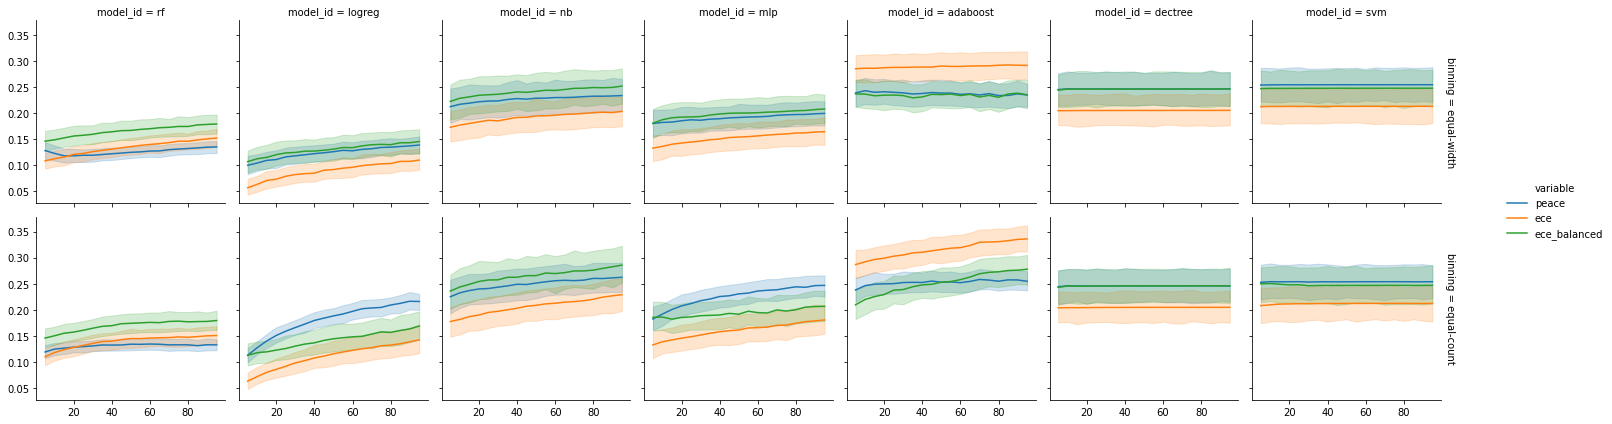

In [11]:
grid = seaborn.FacetGrid(data=melted_df, col="model_id", row="binning", hue="variable", margin_titles=True)
grid.map_dataframe(seaborn.lineplot, x="n_bins", y="value")
grid.add_legend()

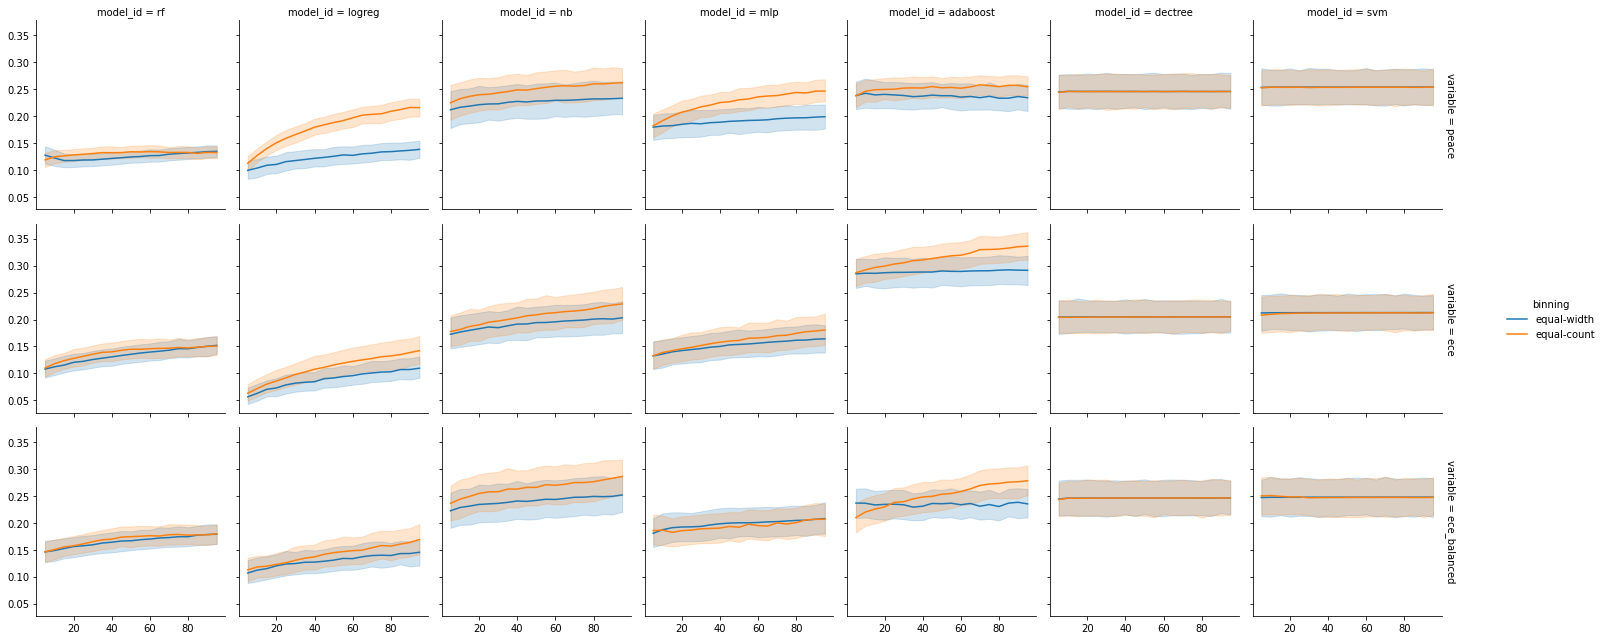

In [12]:
grid = seaborn.FacetGrid(data=melted_df, col="model_id", hue="binning", row="variable", margin_titles=True)
grid.map_dataframe(seaborn.lineplot, x="n_bins", y="value")
grid.add_legend()

In [26]:
df.columns = ["model_id", "task_id", "n_bins", "binning", "Accuracy", "Balanced Accuracy", "F1", "ECE", "Balanced ECE", "PEACE"]
df.head()

,model_id,task_id,n_bins,binning,Accuracy,Balanced Accuracy,F1,ECE,Balanced ECE,PEACE
0,rf,4240,5,equal-width,0.933941,0.769999,0.925897,0.246025,0.219275,0.163441
1,rf,4245,5,equal-width,0.716667,0.683150,0.715005,0.074667,0.088008,0.102191
2,rf,1780,5,equal-width,0.956500,0.956500,0.956500,0.327790,0.328561,0.309834
3,rf,248,5,equal-width,0.725758,0.720469,0.723937,0.077751,0.141831,0.151889
4,rf,1896,5,equal-width,0.967500,0.967500,0.967492,0.287600,0.286672,0.268764


In [43]:
df = df[(df["binning"] == "equal-count") & (df["n_bins"] == 25)].drop(columns=["binning", "n_bins"])

In [54]:
long_df = get_longform(df, subject_cols=["model_id", "task_id"])
long_df.head()

,model_id,task_id,variable,value,subject
0,rf,4240,Accuracy,0.933941,rf_4240
1,rf,4245,Accuracy,0.716667,rf_4245
2,rf,1780,Accuracy,0.956500,rf_1780
3,rf,248,Accuracy,0.725758,rf_248
4,rf,1896,Accuracy,0.967500,rf_1896


## Performance metrics

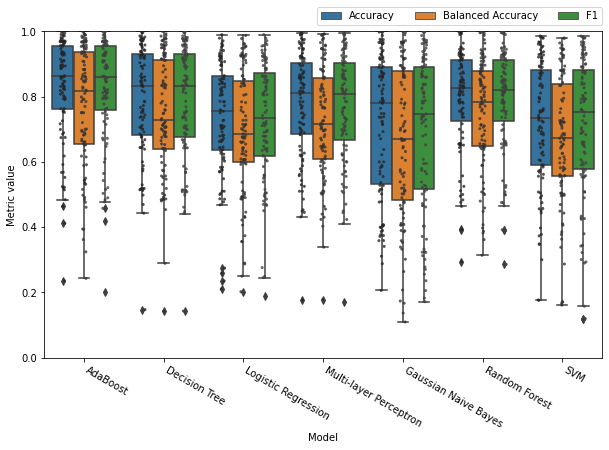

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
seaborn.boxplot(
    data=long_df[long_df["variable"].isin(["Accuracy", "Balanced Accuracy", "F1"])], 
    x="model_id", y="value", hue="variable", saturation=.7, ax=ax
)
seaborn.stripplot(
    data=long_df[long_df["variable"].isin(["Accuracy", "Balanced Accuracy", "F1"])], 
    x="model_id", y="value", hue="variable", dodge=True, color=".25", s=3, alpha=.8, ax=ax
)
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel("Model")
ax.set_ylabel("Metric value")
ax.set_ylim(0, 1)
ax.set_xticklabels(
    ["AdaBoost", "Decision Tree", "Logistic Regression", "Multi-layer Perceptron", "Gaussian Naive Bayes", "Random Forest", "SVM", "XGBoost"],
    rotation=-30, ha="left")

plt.legend(handles[:3], labels[:3], bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right',
           ncol=3, borderaxespad=0.)
plt.savefig("plots/performance.pdf", bbox_inches="tight")

## Statistical testing of calibration metrics

In [46]:
import scipy.stats
import scikit_posthocs as sp

### Friedman

In [47]:
df.head()

,model_id,task_id,Accuracy,Balanced Accuracy,F1,ECE,Balanced ECE,PEACE
0,rf,4240,0.933941,0.769999,0.925897,0.246025,0.231670,0.161811
1,rf,4245,0.716667,0.683150,0.715005,0.154833,0.186361,0.181384
2,rf,1780,0.956500,0.956500,0.956500,0.327790,0.327778,0.241855
3,rf,248,0.725758,0.720469,0.723937,0.088503,0.102401,0.214886
4,rf,1896,0.967500,0.967500,0.967492,0.287600,0.286980,0.207669


In [48]:
def map_stars(p):
    if p < 0.001:
        return "*"
    elif p < 0.01:
        return "*"
    elif p < 0.05:
        return "*"
    else:
        return ""

In [49]:
headers = ["AdaBoost", "DecTree", "LogReg", "MLP", "GNB", "RF", "SVM", "XGBoost"]

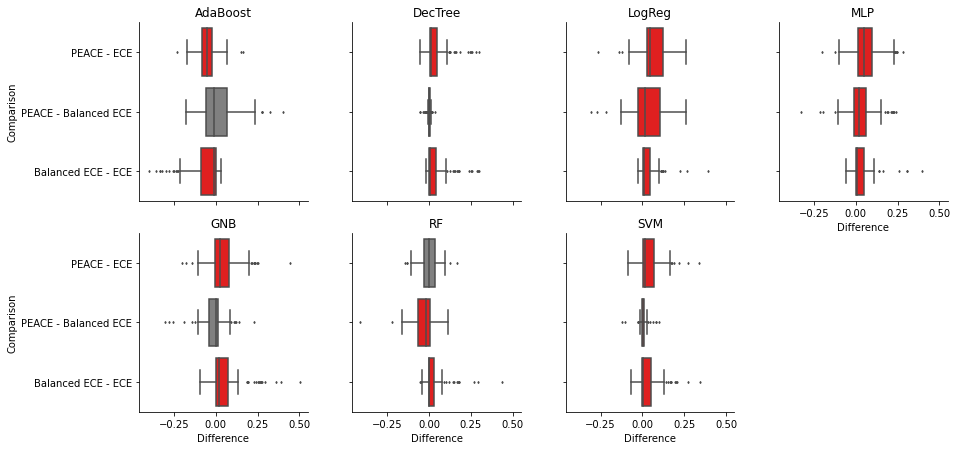

In [56]:
grid = seaborn.FacetGrid(data=df, col="model_id", col_wrap=4)
table_data = [["PEACE - ECE"], ["PEACE - Balanced ECE"], ["Balanced ECE - ECE"]]
for h, ax, (idx, model_df) in zip(headers, grid.axes, df.groupby("model_id")):
    
    diffs = [
        ("PEACE", "ECE"),
        ("PEACE", "Balanced ECE"),
        ("Balanced ECE", "ECE"),
    ]
    
    diff_df = pandas.concat([
        pandas.DataFrame({"value": model_df[d1] - model_df[d2], "diff": f"{d1} - {d2}"})
        for d1, d2 in diffs
    ])
    
    data = model_df.loc[:, cols + ["task_id"]]
    test = scipy.stats.friedmanchisquare(*data.iloc[:, :len(cols)].values.tolist())
    if test.pvalue < 0.05:
        l = get_longform(data.drop(columns=["task_id"]))
        a = sp.posthoc_wilcoxon(a=l, val_col="value", group_col="variable", p_adjust="holm")
        
        colormap = a.copy()
        colormap[a < 0.05] = "red"
        colormap[a >= 0.05] = "grey"
        colors = [colormap[d1][d2] for d1, d2 in diffs]
    else:
        colors = ["grey"]*len(diffs)

    tmp_df = diff_df.groupby("diff").aggregate("mean")
    for i, (col1, col2) in enumerate([["PEACE", "ECE"], ["PEACE", "Balanced ECE"], ["Balanced ECE", "ECE"]]):
        table_data[i].append("$%+.4f$ %s" % (tmp_df.loc[f"{col1} - {col2}"], map_stars(a[col1][col2])))
    
    ax.set_title(h)
    seaborn.boxplot(data=diff_df, y="diff", x="value", orient="h", ax=ax, palette=seaborn.color_palette(colors), fliersize=1.5)
#     seaborn.stripplot(data=diff_df, y="diff", x="value", orient="h", ax=ax, size=3, palette=seaborn.color_palette(colors))#, fliersize=1.5)

grid.set_axis_labels("Difference", "Comparison")
plt.savefig("plots/pairwise_comparisons.pdf", bbox_inches="tight")

In [101]:
print(tabulate.tabulate(table_data, headers=headers, tablefmt="latex").replace("\\$", "$"))

\begin{tabular}{lllllllll}
\hline
                      & AdaBoost    & DecTree     & LogReg      & MLP         & GNB         & RF          & SVM         & XGBoost     \\
\hline
 PEACE - ECE          & $-0.0457$ * & $+0.0421$ * & $+0.0401$ * & $+0.0388$ * & $+0.0400$ * & $+0.0065$   & $+0.0287$ * & $+0.0425$ * \\
 PEACE - Balanced ECE & $+0.0069$   & $+0.0008$ * & $-0.0049$   & $-0.0048$ * & $-0.0112$   & $-0.0272$ * & $-0.0219$   & $-0.0001$ * \\
 Balanced ECE - ECE   & $-0.0526$ * & $+0.0414$ * & $+0.0450$ * & $+0.0437$ * & $+0.0512$ * & $+0.0337$ * & $+0.0507$ * & $+0.0426$ * \\
\hline
\end{tabular}


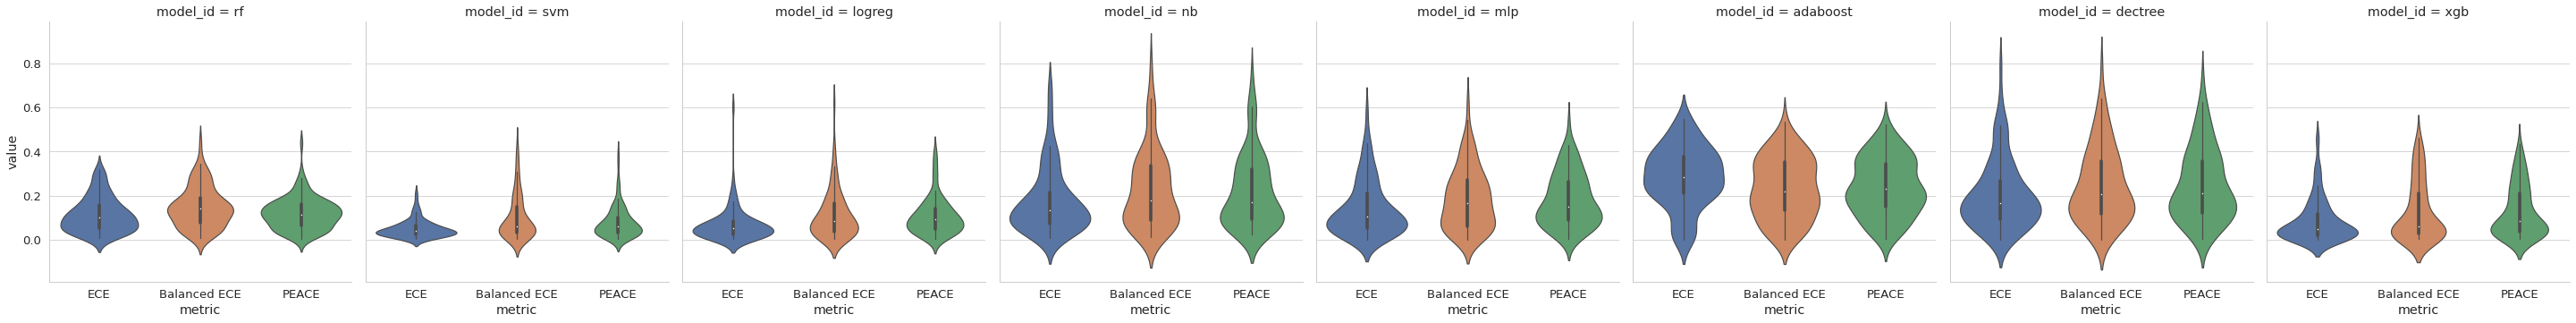

In [82]:
seaborn.catplot(data=long_df[long_df["metric"].isin(cols)], x="metric", y="value", col="model_id", kind="violin")

# Inspect randomly selected datasets

In [102]:
def get_task_meta(task_id):
    task = openml.tasks.get_task(task_id)
    d = task.get_dataset()
    return {
        "Task ID": task_id,
        "# classes": d.qualities["NumberOfClasses"],
        "# features":  d.qualities["NumberOfFeatures"],
        "# instances": d.qualities["NumberOfInstances"],
        "Dataset ID": d.dataset_id,
        "Dataset name": d.name,
        "Dataset URL": d.openml_url,
        "Dataset version": d.version,
        "Dataset creator": ", ".join(d.creator) if type(d.creator) is list else d.creator
    }

In [103]:
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    tasks = pool.map(get_task_meta, df["task_id"].unique())

In [104]:
tasks = pandas.DataFrame(tasks)
tasks.head()

,Task ID,# classes,# features,# instances,Dataset ID,Dataset name,Dataset URL,Dataset version,Dataset creator
0,4240,10.0,7455.0,878.0,400,tr41.wc,https://www.openml.org/d/400,1,None
1,4245,2.0,4.0,120.0,448,analcatdata_boxing1,https://www.openml.org/d/448,1,None
2,1780,10.0,65.0,2000.0,16,mfeat-karhunen,https://www.openml.org/d/16,1,None
3,248,10.0,7.0,2000.0,18,mfeat-morphological,https://www.openml.org/d/18,1,None
4,1896,10.0,65.0,2000.0,16,mfeat-karhunen,https://www.openml.org/d/16,1,None


In [105]:
with open("task_table.tex", "w") as fp:
    fp.write(tabulate.tabulate(
        tasks[["Task ID", "Dataset ID", "Dataset name", "Dataset version", "# classes", "# features", "# instances"]].values, 
        headers=["Task ID", "Dataset ID", "Dataset name", "Dataset version", "# classes", "# features", "# instances"],
        tablefmt="latex"))

In [106]:
table = tasks.merge(df, right_on="task_id", left_on="Task ID")

In [107]:
tasks["# instances"].describe()

count      99.000000
mean     1130.717172
std      1096.165692
min       101.000000
25%       250.000000
50%       913.000000
75%      2000.000000
max      4601.000000
Name: # instances, dtype: float64

In [108]:
table["PEACE-ECE"] = table["PEACE"] - table["ECE"]

In [109]:
table["PEACE-balECE"] = table["PEACE"] - table["Balanced ECE"]
table["PEACE>=balECE"] = table["PEACE"] >= table["Balanced ECE"]

In [110]:
selector = table["model_id"] == "mlp"

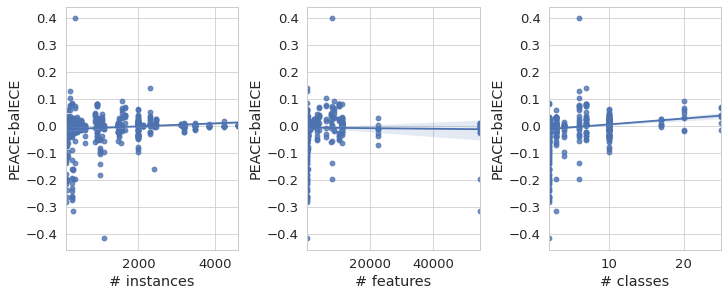

In [111]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
seaborn.regplot(data=table, x="# instances", y="PEACE-balECE", ax=ax[0])
seaborn.regplot(data=table, x="# features", y="PEACE-balECE", ax=ax[1])
seaborn.regplot(data=table, x="# classes", y="PEACE-balECE", ax=ax[2])

In [123]:
table[["# instances", "# classes", "# features", "PEACE-balECE", "Task ID"]].groupby("Task ID").aggregate("mean").corr()

,# instances,# classes,# features,PEACE-balECE
# instances,1.000000,0.255930,-0.173291,0.193052
# classes,0.255930,1.000000,0.021540,0.290773
# features,-0.173291,0.021540,1.000000,-0.029596
PEACE-balECE,0.193052,0.290773,-0.029596,1.000000


# AdaBoost

In [ ]:
from functools import partial

In [ ]:
row = grouped_df.iloc[(grouped_df["PEACE"] - grouped_df["ECE"]).sort_values().index[0]]

In [ ]:
def func(model):
    X, y, splitter, task_id = load_openml_task(row["task_id"])

    y_probs = [[]]*splitter.get_n_splits()
    y_preds = [[]]*splitter.get_n_splits()
    y_test = [[]]*splitter.get_n_splits()

    for i, (train_idx, test_idx) in enumerate(splitter.split()):
        # split data
        Xt, yt = X[train_idx], y[train_idx]
        Xv, yv = X[test_idx], y[test_idx]

        # train adaboost
        model_instance = model()
        model_instance.fit(Xt, yt)

        y_probs[i] = model_instance.predict_proba(Xv)
        y_preds[i] = model_instance.predict(Xv)
        y_test[i] = yv
        
    return y_probs, y_preds, y_test

In [ ]:
ada_data = func(sklearn.ensemble.AdaBoostClassifier)

In [ ]:
logreg_data = func(partial(sklearn.linear_model.LogisticRegression, max_iter=1000))

In [ ]:
svm_data = func(partial(sklearn.svm.SVC, max_iter=1000, probability=True))

In [ ]:
mlp_data = func(partial(sklearn.neural_network.MLPClassifier, max_iter=1000))

In [ ]:
rf_data = func(sklearn.ensemble.RandomForestClassifier)

In [ ]:
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20, 4))

for ax, data in zip(axes, [ada_data, logreg_data, svm_data, mlp_data, rf_data]):
    y_probs = numpy.hstack([p.max(axis=1) for p in data[0]])
    y_preds = numpy.hstack(data[1])
    y_test = numpy.hstack(data[2])
    ax.set_title(f"ECE: {metrics.ece(y_probs, y_preds, y_test, bins=15):.3f}, PEACE: {metrics.peace(y_probs, y_preds, y_test, bins=15):.3f}")

    seaborn.histplot(y_probs, ax=ax, bins=numpy.histogram_bin_edges(y_probs, bins=15, range=(0,1)))

In [ ]:
plots.river_reliability_diagram(mlp_data[0][i].max(axis=1), mlp_data[1][i], mlp_data[2][i], bins=15)

In [ ]:
plots.river_reliability_diagram(logreg_data[0][i].max(axis=1), logreg_data[1][i], logreg_data[2][i], bins=15)

In [ ]:
plots.confidence_reliability_diagram(ada_data[0][i].max(axis=1), ada_data[1][i], ada_data[2][i], bins=15)

In [ ]:
plots.confidence_reliability_diagram(logreg_data[0][i].max(axis=1), logreg_data[1][i], logreg_data[2][i], bins=15)